<center>
    <h1> ILI286 - Computación Científica II  </h1>
    <h2> Tarea 5 </h2>
    <h2> 21 de noviembre del 2016</h2>
    <h4> Roberto Felipe Fuentes Zenteno - 201173037-2 - roberto.fuentes@alumnos.usm.cl</h4>
</center>

# Tabla de Contenidos
* [1.- Introducción](#int)
* [2.- Pregunta 1](#preg1)
* [3.- Pregunta 2](#preg2)
* [4.- Pregunta 3](#preg3)
* [5.- Bonus](#bonus)
    * [1.- Pregunta 1](#bonus1)
    * [2.- Pregunta 2](#bonus2)
* [7.- Conclusión](#con)
* [8.- Referencias](#ref)

### Librerías necesarias

In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt
from matplotlib import gridspec
from ipywidgets import widgets

<div id='preg1' />
## Pregunta 1 ##

Definimos nuestra función de _diritchlet_ para resolver siguiente ecuación de ondas, acotada por las siguientes condiciones de borde para$ x \in [-10,10] \ \ $ y $t \in [0,20] \ \ $:
\begin{align*}
u_{tt}(x,t) &= c^2\, u_{xx}(x,t) \\
u(x,0) &= f(x) =  0.1e^{-x^2}\\
u_t(x,0) &= g(x) = 0\\
u(-10,t) &= u(10,t)\\
\end{align*}

Usando un $\Delta x = 0.2$ y $\Delta t = 0.1$, y considerando $c^2 = 4$. Para esto debemos realizar diferencias finitas:

\begin{align*}
u_{tt}(x,t) &= c^2\, u_{xx}(x,t) \\
\dfrac{u_{i,t+1}-2u_{i,t} +u_{i,t-1}}{\Delta t^2} &= c^2\, \dfrac{u_{i+1,t}-2u_{i,t} +u_{i-1,t}}{\Delta x^2} 
\end{align*}

Aqui Nuestra incógnita es $u_{i,t+1}$, la cual despejaremos con la información de los dos tiempos anteriores. Por lo tanto, despejando llegamos a:

$$u_{i,t+1} = \dfrac{c^2 \Delta t^2}{\Delta x^2} u_{i+1,t} + 2\left(1 - \dfrac{c^2 \Delta t^2}{\Delta x^2}\right)u_{i,t} + \dfrac{c^2 \Delta t^2}{\Delta x^2} u_{i-1,t}- u_{i,t-1}$$

Haciendo $\dfrac{c^2 \Delta t^2}{\Delta x^2} = \sigma$, tenemos que:
$$u_{i,t+1} = \sigma^2 u_{i+1,t} + 2\left(1 - \sigma^2\right)u_{i,t} +  \sigma^2 u_{i-1,t} - u_{i,t-1}$$

Debemos analizar el caso inicial, ya que al reemplazar nuestra ecuación en $t = 0$, nos queda:
$$u_{i,1} = \sigma^2 u_{i+1,1} + 2\left(1 - \sigma^2\right)u_{i,1} + \sigma^2 u_{i-1,1}- u_{i,-1}$$

Aqui no tenemos $u_{i,-1}$, por lo que debemos encontrarlo. Gracias a nuestra condición con derivada y usando _central difference_, tenemos:

$$u_t = \dfrac{u_{i,t+1} - u_{i,t-1}}{2\Delta t} = 0$$

Reemplazando en t = 0 y despejando tenemos que:

$$u_{i,-1} = u_{i,1}$$

Reemplazando en la ecuación anterior, nos quedan las siguientes ecuaciones para los tiempos $t = 1$ y $t = 2\cdots$:

\begin{align*}
u_{i,t+1} &= \sigma^2 u_{i+1,t} + \left(1 - \sigma^2\right)u_{i,t} + \sigma^2 u_{i-1,t} + \Delta t u_t \\
u_{i,1} &= \dfrac{\sigma^2}{2} u_{i+1,0} + \left(1 - \sigma^2\right)u_{i,0} + \dfrac{\sigma^2}{2} u_{i-1,0}  + \Delta t u_t(x_i,0)
\end{align*}

Finalmente uasndo las condiciones periodicas, debemos cambiar el arreglo _tmp_, ya que no recibimos _l(t)_ y _r(t)_ como parámetros, sino que tenemos una ecuación mas de donde sacar información. Si dibujamos el punto inicial (es decir $w_{0,0}$), al momento de obtener el punto $w_{-1,0}$, tendremos que aprovechar nuestras condiciones periodicas, por lo que tendremos que mirar el punto $w_{Nx-1,0}$, el cual es el penultimo punto del otro extremo, y de forma analoga al momento de analizar $w_{N_x+1,1}$ tendremos que ver el punto $w_{1,0}$. 
Implementando esto en codigo tenemos:

In [2]:
def periodic_diritchlet(f,g,c,dx,dt,M,N):
    
    #Generamos el arreglo de puntos.
    x = np.linspace(-10,10,N)
    t = np.linspace(0,20,M)
    
    sigma = c**2 * (dt/dx)**2
    
    if(sigma <= 1):
        print("Se cumple condicion CFL, sigma**2 = " + str(sigma))
    else:
        print("No se cumple condicion CFL, sigma**2 = " + str(sigma))
        
    #Generamos un arreglo de del tamaño de la discretizacion (en el caso particular de la pregunta 1, de 200x100).
    w = np.zeros((M,N))
    
    #Llenamos la primera fila con la informacion que sabemos, u(x,0) = f(x). 
    w[0,:] = f(x)
    
    #Creamos una matriz tridiagonal con los coeficientes correspondientes: en la diagonal A_i,j = 2-2*sigma, y A_i,j+1 y A_i,j-1 = sigma.
    B = np.zeros(N)
    B[0] = 2 - 2*sigma
    B[1] = sigma
    A = spla.toeplitz(B)
    #Llenamos la primera y ultima fila de esta matriz con 0, asi podremos sumar directamente los bordes.
    #A[0,:] = np.zeros(A.shape[0])
    #A[-1,:] = np.zeros(A.shape[-1])
    
    #Para el primer caso asignamos lo presentado anteriormente.
    C_t = np.zeros(N)
    C_t[0] = w[0,-2]
    C_t[-1] = w[0, 1]
    w[1,:] = 0.5 * np.dot(A, w[0,:]) + dt*g + 0.5*sigma*C_t
    
    #Para el resto de caso (t=2 hacia adelante) agregamos los coeficientes como se indico anteriormente.
    for k in range(2,M):
        C_t[0] = w[k-1, -2]
        C_t[-1] = w[k-1, 1]
        w[k] = np.dot(A, w[k-1,:]) +  sigma*C_t - w[k-2,:]
        
    return x,w,dt,t

In [3]:
#Definimos la funcion para graficar, 
def plot_diritchlet(us,i=0):
    plt.figure(figsize=(10,8))
    plt.plot(x,us[i,:],'--bo',color = 'black')
    plt.ylim(-0.05,0.11)
    plt.xlim(-10,10)
    plt.title('Tiempo: '+str(i*dt))
    plt.grid()
    plt.ylabel('w(x,t)',fontsize=20)
    plt.xlabel('x',fontsize=20)
    plt.show()

Luego damos los valores iniciales correspondientes a la tarea, los cuales fueron nombrados anteriormente:

In [4]:
N=100
M=200

c = 2

dx = 0.2
dt = 0.1

# u(x,0)=f(x)
f = lambda x: 0.1*np.exp(-x**2)

# u_t(x,0)=g(x)
g_1 = np.zeros(N)

x,u,dt,t = periodic_diritchlet(f,g_1,c,dx,dt,M,N)

Se cumple condicion CFL, sigma**2 = 1.0


Finalmente graficos nuestra solución usando la variable _t_ como la variable independiente, e iremos mirando como se comporta el grafico a medida que avanza el tiempo:

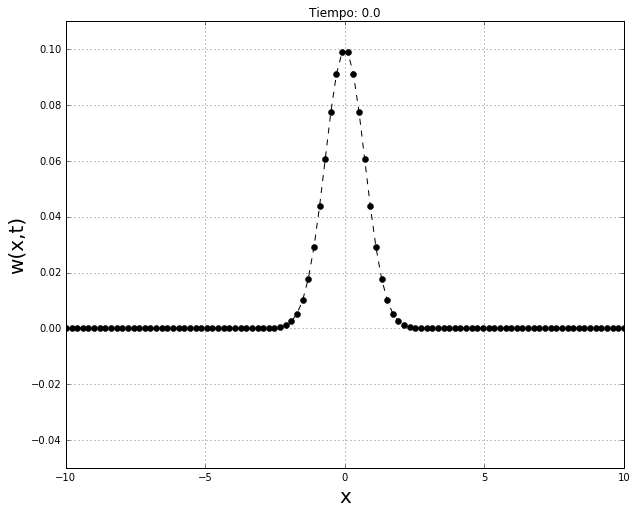

<function __main__.plot_diritchlet>

In [5]:
dp = 1
widgets.interact(plot_diritchlet,us=widgets.fixed(u),i=(0,199,dp))

Observamos que efectivamente en u(x,0), nuestra función original es _f(x)_, y a medida que avanza el tiempo vemos como esta se transforma en 2 ondas de amplitud 0.05. A medida que avanza el tiempo nos damos cuenta que basicamente eran 2 ondas de amplitud 0.05, que justo en el tiempo 0 estaban superpuestas. Siguiendo con el analisis, despues de cierto tiempo, las ondas llegan al borde, donde se superponen nuevamente con otras ondas, alcanzando nuevamente una amplitud de 0.1. Finalmente, las ondas se devuelven y se vuelven a juntar. Esto sucede gracias a la propiedad de superposición de la onda. Es importante destacar ademas que la superposicion ocurre justamente en x = -10 y x = 10, las cuales son justamente las condiciones de la ecuación de la onda. Finalmente, cabe destacar que como se trata de una condicion periodica, esto se debera repetir si las ondas viajan en el mismo sentido y se encuentran en una misma fase. 

<div id='preg2' />
## Pregunta 2 ##

Nos preguntan que sucede cuando modificamos $\Delta t$ , $\Delta x$ o _c_ para que $\sigma^2 = \left(\dfrac{c \Delta t}{ \Delta x}\right)^2$ sea mucho mas grande y pequeño que 1  ( $\sigma^2 \gg 1$ y $\sigma^2 \ll 1$). Para esto crearemos una función donde a través de un widget se graficarán las 2 soluciones con ambos $\sigma^2$, y se analizara que es lo que sucede a medida que aumenta el tiempo.


In [6]:
def plot_sigma(us,i=0):
    #Grafica para sigma muy pequeño
    fig = plt.figure(figsize=(14, 5)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3]) 
    ax0 = plt.subplot(gs[0])
    ax0.plot(x,us[0][i,:],'--bo',color = 'green')
    plt.grid(True)
    plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
    plt.title("Sigma << 1",fontsize = 14, verticalalignment = 'baseline', horizontalalignment = 'center')
    plt.xlim(-10,10)
    plt.axis('tight')
    ax0.set_ylim(-0.11, 0.11)
    plt.xlabel("w(x,t)", fontsize = 14)
    plt.ylabel("x", fontsize = 14)
    
    #grafico para sigma muy grande
    ax1 = plt.subplot(gs[1])
    ax1.plot(x,us[1][i,:],'--bo',color = 'red')
    plt.grid(True)
    plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
    plt.xlim(-10,10)
    plt.title("Sigma >> 1",fontsize = 14, verticalalignment = 'baseline', horizontalalignment = 'center')
    plt.axis('tight')
    #Si se apreciar un mejor comportamiento de la onda desde lejos, se recomienda comenta ax1.set_ylimit.
    ax1.set_ylim(-0.11, 0.11)
    plt.xlabel("w(x,t)", fontsize = 14)
    plt.ylabel("x", fontsize = 14)

    plt.show()

Finalmente daremos valores de tal forma que los sigmas queden mucho mas grandes y pequeños que uno. Para este caso, veremos la comparación entre $\sigma^2$ = 0.0625 y $\sigma^2$ = 6.25. Para esto, vemos que sucedera al momento de varias _c_ en nuestro grafico (haciendo _c_ muy grande y muy pequeño):

In [7]:
#Creamos una lista para guardar las 2 matrices con distintos sigmas
uv = []
#Para un sigma muy pequeño

c_litte = 0.5

x,u1,dt,t = periodic_diritchlet(f,g_1,c_litte,dx,dt,M,N)
uv.append(u1)

Se cumple condicion CFL, sigma**2 = 0.0625


In [8]:
#Para un sigma muy grande
c_bigger = 5

dx = 0.2
dt = 0.1
x,u2,dt,t = periodic_diritchlet(f,g_1,c_bigger,dx,dt,M,N)
uv.append(u2)

No se cumple condicion CFL, sigma**2 = 6.25


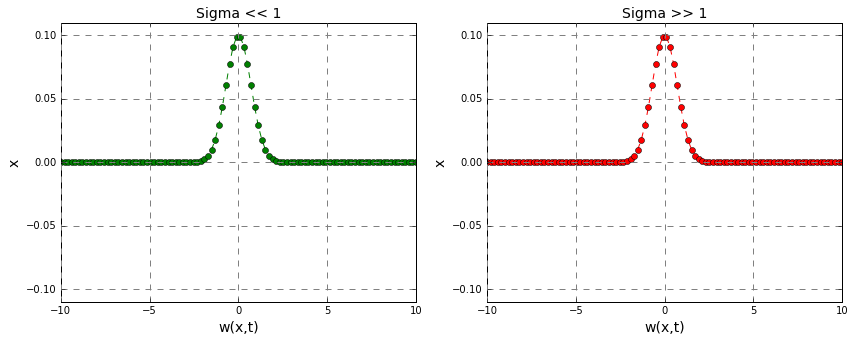

<function __main__.plot_sigma>

In [9]:
dp = 1
widgets.interact(plot_sigma,us=widgets.fixed(uv),i=(0,150,dp))

### ¿Qué sucede al variar _c_? ¿Cómo afecta esto a $\sigma$?

* Para un $\sigma^2$ muy grande:

    Lo que hicimos aqui fue aumetar c de 2 a 5, lo cual hace que la condicion CFL no se cumpla. Aquí, la onda empieza a diverger, mostrandonos que a medida que aumenta el tiempo empieza a entregarnos resultados errornes y cada vez mas grandes. Aqui podemos concluir que entre mas grande sea nuestro $\sigma$ empezara a oscilar y entregar resultados en cada vez menos tiempo.
    
* Para un $\sigma^2$ muy pequeño:

    Para lograr esto, se disminuye ahora _c_ a 0.5. Al ver la simulación, vemos que la onda empieza a converger y a mostrarnos el mismo resultado que el ejercicio anterior, con la diferencia de que la onda avanza sumamente lento en comparación al primer gráfico, por lo que podemos concluir que a medida que $\sigma$ es mas bajo, mas tardará el algortimo en mostrarnos un resultado correcto en el tiempo y espacio correspondiente.

<div id='preg3' />
## Pregunta 3 ##

Para este ejercicio se evaluaran las mismas condiciones que se implementaron con la pregunta 1, y con el mismo _c_. Sin embargo, sera nuestra función _g(x)_ la que cambiara, pasando de 0 a la siguiente función:

$$ u_t(x,0) = g(x)= \frac{1}{2}(e^{-(x-0.2)^2} - e^{-(x+0.2)^2})$$

In [10]:
# u_t(x,0)=g(x)
g_2 = 0.5*(np.exp(-(x-0.2)**2) - np.exp(-(x+0.2)**2))

x,u3,dt,t = periodic_diritchlet(f,g_2,c,dx,dt,M,N)

Se cumple condicion CFL, sigma**2 = 1.0


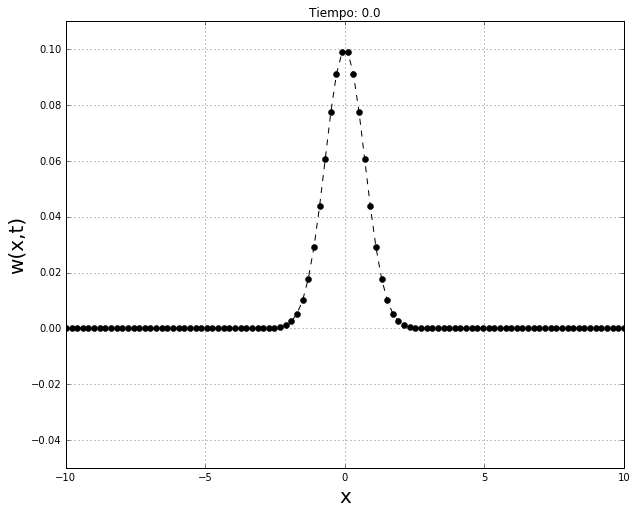

<function __main__.plot_diritchlet>

In [11]:
dp = 1
widgets.interact(plot_diritchlet,us=widgets.fixed(u3),i=(0,199,dp))

Aqui observamos que, al igual que el caso inicial la onda parte con una amplitud de 0.1, es decir, las 2 ondas estan superpuestas. Sin embargo, a medida que avanza el tiempo, vemos que las 2 ondas viajan de manera superpuesta a lo largo del tiempo. Esto nos da a entender que las 2 ondas con amplitud 0.05 ahora viajabn con la misma fase y en el mismo sentido, estando superpuestas siempre. Podemos concluir entonces que la funcion $g(x) \ne 0$ claramente afecta el comportamiento de la onda, haciendo que se comporte de otra forma (en este caso, dando una superposición perfecta a medida que el tiempo avanza).

Si esto lo llevamos al plano fisico, se observa que esta simulación es una <b>_Interferencia Constructiva_</b>, interferencia que se da cuando el desfase de las ondas es <b>un múltiplo par de $\pi$ </b> o <b>si están desfasados en un número entero de longitudes de onda</b>. Esto hace que las ondas coincidan perfectamente, y su amplitud sea el doble de una.

<div id='bonus' />
## Bonus ##

<div id='bonus1' />
### Pregunta 1 ###

Para esta pregunta, nos piden calcular de nuevo la misma ecuacion, pero cambiando las condiciones periodicas, por condiciones de _Neummann_:

$$u_x(x_0,t) = u_x(x_N,t) = 0$$ 

In [12]:
def periodic_neummann_bonus_1(f,g,c,dx,dt,M,N,bonus):
    
    #Generamos el arreglo de puntos.
    
    x = np.linspace(-10,10,N) 
    t = np.linspace(0,20,M)
        
    sigma = c**2 * (dt/dx)**2
    
    if(sigma <= 1):
        print("Se cumple condicion CFL, sigma**2 = " + str(sigma))
    else:
        print("No se cumple condicion CFL, sigma**2 = " + str(sigma))
        
    #Generamos un arreglo de del tamaño de la discretizacion (en el caso particular de la pregunta 1, de 200x100).
    w = np.zeros((M,N))
    
    #Llenamos la primera fila con la informacion que sabemos, u(x,0) = f(x). 
    w[0,:] = f(x)
    
    #Creamos una matriz tridiagonal con los coeficientes correspondientes: en la diagonal A_i,j = 2-2*sigma, y A_i,j+1 y A_i,j-1 = sigma.
    B = np.zeros(N)
    B[0] = 2 - 2*sigma
    B[1] = sigma
    A = spla.toeplitz(B)
    #Llenamos la primera y ultima fila de esta matriz con 0, asi podremos sumar directamente los bordes.
    #A[0,:] = np.zeros(A.shape[0])
    #A[-1,:] = np.zeros(A.shape[-1])
    
    #Para el primer caso asignamos lo presentado anteriormente.
    C_t = np.zeros(N)
    C_t[0] = w[0,1]
    C_t[-1] = w[0, -2]
    w[1] = 0.5 * np.dot(A, w[0]) + dt*g + 0.5*sigma*C_t
    
    #Para el resto de caso (t=2 hacia adelante) agregamos los coeficientes como se indico anteriormente.
    for k in range(2,M):
        C_t[0] = w[k-1, 1]
        C_t[-1] = w[k-1, -2]
        w[k] = np.dot(A, w[k-1]) +  sigma*C_t - w[k-2]
        
    return x,w,dt,t

In [13]:
#Definimos la funcion para graficar, 
def plot_neummann_bonus1(us,i=0):
    plt.figure(figsize=(10,8))
    plt.plot(x,us[i,:],'--bo',color = 'blue')
    plt.ylim(-0.05,0.21)
    plt.xlim(-10,10)
    plt.title('Tiempo: '+str(i*dt))
    plt.grid()
    plt.ylabel('w(x,t)',fontsize=20)
    plt.xlabel('x',fontsize=20)
    plt.show()

In [14]:
x,u4,dt,t = periodic_neummann_bonus_1(f,g_2,c,dx,dt,M,N,1)

Se cumple condicion CFL, sigma**2 = 1.0


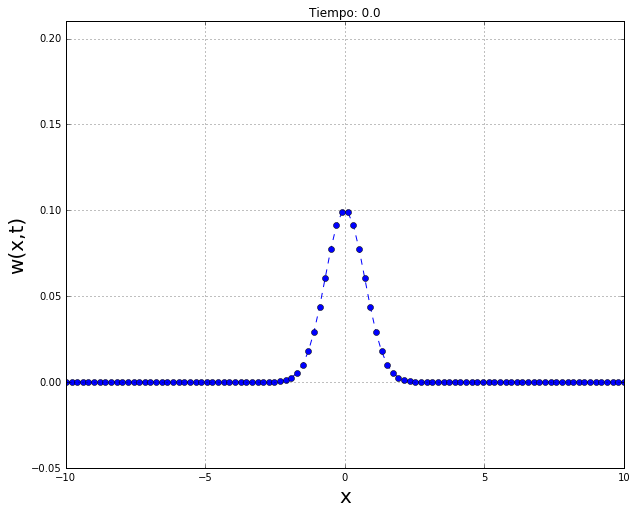

<function __main__.plot_neummann_bonus1>

In [15]:
dp = 1
widgets.interact(plot_neummann_bonus1,us=widgets.fixed(u4),i=(0,199,dp))

Aqui observamos que el comportamiento de la onda es similar al problema 3, es decir, son 2 ondas que van superpuestas a cada minuto. Sin embargo, las ondas ahora se superponen con otras 2 ondas superpuestas que vienen en sentido contrario, superponiendose en los bordes y creando una superposición aun mas grande (una onda con amplitud 0.2). 

<div id='bonus2' />
### Pregunta 2 ###

Aqui se realizará una comparación de la simulación generada con la discretizacion de nuestra EDP contra la solución real del problema, la cual viene dada por la siguiente expresión:

$$ u(x,t) = 0.1e^{-(x-2t)^2} $$

Debemos tener en cuenta ademas que el dominio de _x_ es ahora de -10 a 50, por lo que ahora podremos apreciar con mayor plenitud como se comporta nuestra onda en contraste a la solución real.

In [16]:
def periodic_neumman_bonus_2(f,g,c,dx,dt,N,M):
    
    #Generamos el arreglo de puntos. Aqui agrandamos el rango de x a [-10,50]
    x = np.linspace(-10,50,N)
    t = np.linspace(0,20,M)
    
    sigma = c**2 * (dt/dx)**2

    if(sigma <= 1):
        print("Se cumple condicion CFL, sigma**2 = " + str(sigma))
    else:
        print("No se cumple condicion CFL, sigma**2 = " + str(sigma))
        
    #Generamos un arreglo de del tamaño de la discretizacion (en el caso particular de la pregunta 1, de 200x100).
    w = np.zeros((M,N))
    
    #Llenamos la primera fila con la informacion que sabemos, u(x,0) = f(x). 
    w[0,:] = f(x)
    
    #Creamos una matriz tridiagonal con los coeficientes correspondientes: en la diagonal A_i,j = 2-2*sigma, y A_i,j+1 y A_i,j-1 = sigma.
    B = np.zeros(N)
    B[0] = 2 - 2*sigma
    B[1] = sigma
    A = spla.toeplitz(B)
    #Llenamos la primera y ultima fila de esta matriz con 0, asi podremos sumar directamente los bordes.
    #A[0,:] = np.zeros(A.shape[0])
    #A[-1,:] = np.zeros(A.shape[-1])
    
    #Para el primer caso asignamos lo presentado anteriormente.
    C_t = np.zeros(N)
    C_t[0] = w[0,1]
    C_t[-1] = w[0, -2]
    w[1] = 0.5 * np.dot(A, w[0]) + dt*g(x) + 0.5*sigma*C_t
    
    #Para el resto de caso (t=2 hacia adelante) agregamos los coeficientes como se indico anteriormente.
    for k in range(2,M):
        C_t[0] = w[k-1, 1]
        C_t[-1] = w[k-1, -2]
        w[k] = np.dot(A, w[k-1]) +  sigma*C_t - w[k-2]
        
    return x,w,dt,t

In [17]:
#Funcion para graficar el bonus 2
def plot_neumman_bonus2(us,i=0):
    plt.figure(figsize=(10,7))
    #Grafica de funcion generada por discretizacion
    plt.plot(x_neummann,us[i,:],'--bo',color = 'red',label = 'función aproximada')
    plt.hold(True)
    #Grafica funcion real 
    plt.plot(x_neummann, 0.1*np.exp(-(x_neummann - 2*i*dt)**2),'--bo',color = 'green', label = 'función real')
    plt.ylim(-0.01,0.11)
    plt.xlim(-10,50)
    plt.title('Tiempo: '+str(i*dt))
    plt.grid()
    plt.legend(loc=1)
    plt.ylabel('w(x,t)',fontsize=20)
    plt.xlabel('x',fontsize=20)
    plt.show()

In [18]:
#Damos nuevos valores a la ecuacion ya que nuestro rango en en x aumento.
N_neummann=300
M=200

c = 2

dx = 0.2
dt = 0.1

# u(x,0)=f(x)
f = lambda x: 0.1*np.exp(-x**2)

# u_t(x,0)=g(x)
g_2 = lambda x: 0.5*(np.exp(-(x-0.2)**2) - np.exp(-(x+0.2)**2))

x_neummann,u5,dt,t = periodic_neumman_bonus_2(f,g_2,c,dx,dt,N_neummann,M)

#Creamos una matriz con los valores de la solucion real.
resultado_real = []
temp = []
for i in range(len(t)):
    for j in range(len(x_neummann)):
        temp.append(0.1*np.exp(-(x_neummann[j] - 2*t[i])**2))
    resultado_real.append(temp)
    temp = []

Se cumple condicion CFL, sigma**2 = 1.0


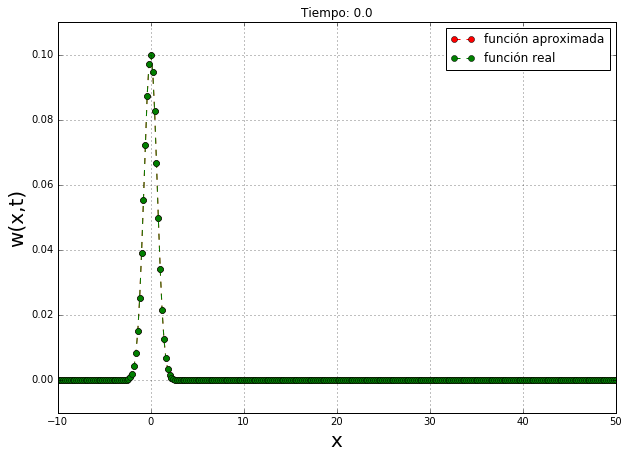

<function __main__.plot_neumman_bonus2>

In [19]:
dp = 1
widgets.interact(plot_neumman_bonus2,us=widgets.fixed(u5),i=(0,199,dp))

Observamos que las 2 graficas parten exactamente iguales, pero a medida que empieza a pasar el tiempo, la gráficad de nuestra solucion empieza a desfazarse con respecto a la onda original, lo que nos da un indicio de que existe un error. Para esto, creamos una funcion _compute error_, la cual recibira nuestra solución y la solución real, restara las 2 soluciones y sacara el maximo de cada fila, obteniendo asi los errores maximos por cada fila:  

In [20]:
def compute_error(x_sol1,x_sol2):
    return np.amax(x_sol1-x_sol2,axis=1)

In [21]:
#Funcion para graficar el error
def plot_error(error):
    iteration = list(range(0,len(error)))
    plt.figure(figsize=(10,8))
    plt.semilogy(iteration,error,'--bo',color = 'black')
    plt.ylim(7e-5,1e-2)
    plt.title('Tiempo t_i vs error',fontsize=20)
    plt.grid()
    plt.xlabel('Tiempo',fontsize=20)
    plt.ylabel('error',fontsize=20)
    plt.show()

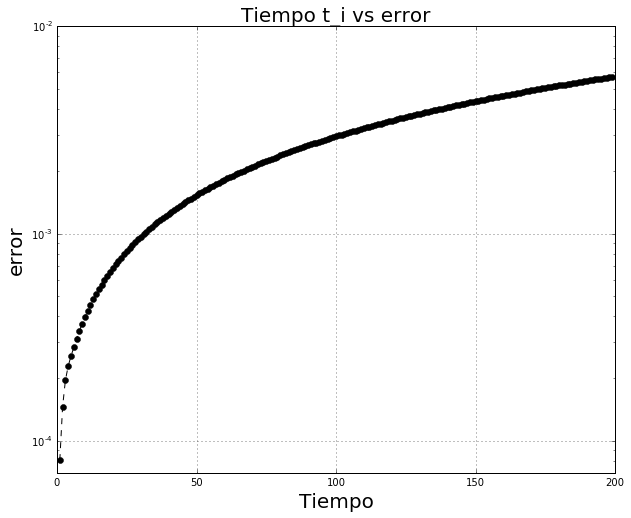

In [22]:
#Calculamos el error y lo graficamos.
error = compute_error(resultado_real, u5)
plot_error(error)

Observamos que el error en el tiempo 0 es claramente 0, puesto que al inicio la onda se comportara segun la condicion de borde, lo que hace que las 2 soluciones sean iguales. Sin embargo, a medida que aumenta el tiempo los errores empiezan a aumentar, lo cual se puede apreciar en la grafica. Esto se puede comportar de una mejor manera si encontramos otra discretizacion que sea mas adecuada al problema. 

Logramos deducir según nuestro gráfico que en la región en la cual estamos estimando la solución por _diferencias finitas_ es de aproximadamente $10^{-2}$, lo cual es un error que si bien no es tan pequeño como se esperaria,es un error bastante bueno y que simula de manera bastante buena el comportamiento de la onda,

<div id='con' />
## Conclusiones ##

Gracias a este laboratorio, hemos podido graficar el comportamiento de una onda periódica en su totalidad. Además, dependiendo de las condiciones de borde de la onda, esta se comporta de distintas maneras, pudiendo ver asi como las ondas se juntaban y formaban una gran onda gracias al principio de superposición, como tambien conceptos de gran relevancia como la fase, la amplitud y la interferencia. 

Es importante destacar la condición _CFL_ de las ondas hiperbólicas, puesto que si no controlamos de forma correcta estos parámetros, puede que nuestra simulación no sea la más acorde a nuestra solución (como se comprobó en la pregunta 2 del laboratorio).

Por otra parte, comprobamos que las simulaciones que realizamos de las ondas son bastantes cercanas a la realidad (en la ultima pregunta del bonus, pudimos comprobar que el error respecto a la ecuación original es bastante poca). Cabe destacar que dependiendo de los parámetros que le demos a la onda, y de que tan bien construyamos nuestro algoritmo, podremos ver una simulación casi perfecta de la onda. Finalmente con estos algoritmos para contruir una EDP de ondas (Hiperbólica), ademas del bajo error de estas simulaciones, podemos realizar grandes experimentos, pudiendo así resolver incontables problemas que existen en la vida real.

<div id='ref' />
## Referencias ##

"_Superposición de las ondas_"
- http://laplace.us.es/wiki/index.php/Superposición_de_ondas

"_Descripción de una onda_"

- https://es.wikipedia.org/wiki/Onda

"_Numerical Analysis, 2nd Edition, Timothy Sauer, Chapter 8_"